# Model

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import folium

from sklearn.metrics import confusion_matrix

import networkx as nx

import pickle

In [2]:
%load_ext rpy2.ipython

## Distances To Hyde Park

In [3]:
with open('../analysis/distances_to_hyde.pickle', 'rb') as f:
    distances_to_hyde_park = pickle.load(f)

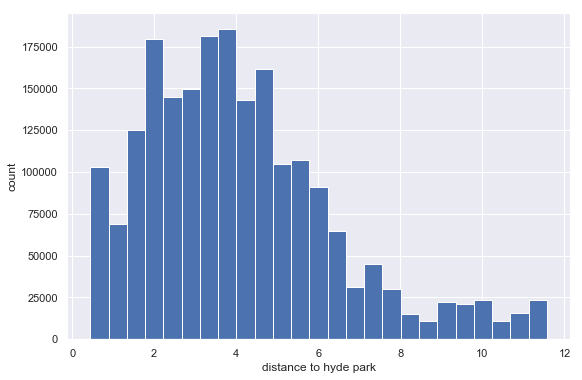

In [4]:
plt.figure(figsize=(9, 6))
plt.hist(distances_to_hyde_park, bins=25)
plt.xlabel('distance to hyde park')
plt.ylabel('count')
plt.savefig('img/distances_to_hyde_park.pdf')

In [5]:
len(distances_to_hyde_park) / 2

1029716.0

In [6]:
print('mean: {}'.format(np.mean(distances_to_hyde_park)))
print('var: {}'.format(np.var(distances_to_hyde_park)))

mean: 4.093992008693341
var: 5.451673550184093


In [7]:
G = nx.read_gml('../data/final/trips.gml')

In [8]:
F = nx.read_gml('../analysis/generated_trips.gml')

## Degrees

In [9]:
degrees = [i[1] for i in G.degree]
generated_degrees = [i[1] for i in F.degree]

In [10]:
%%R -o fitted_degrees
library('MASS')
fitted_degrees = rnegbin(782, 2633.544757, 2.347911)

In [11]:
fitted_degrees = list(fitted_degrees)

In [12]:
plt.figure(figsize=(20, 8))
plt.hist([degrees, fitted_degrees, generated_degrees], bins=25, rwidth=0.8)
plt.xlabel('degree')
plt.ylabel('count')
plt.legend(['observed', 'fitted', 'generated'])
plt.savefig('img/degree_distribution3.pdf')

In [13]:
generated_fitted = pd.DataFrame({'generated' : generated_degrees, 'fitted': fitted_degrees})
generated_fitted = generated_fitted.apply(pd.Series.value_counts).fillna(0)
generated_fitted = generated_fitted.values

In [14]:
%%R -i generated_fitted
fisher.test(generated_fitted, simulate.p.value=TRUE)


	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  generated_fitted
p-value = 0.4408
alternative hypothesis: two.sided



## Communities

In [15]:
modularities = pd.read_csv('../analysis/generated_modularity_grid_search.csv')
modularities.sort_values('modularity', ascending=False).head()

resolution  random  useWeight modularity  components
20        1,0   False       True    0,25700           3
18        0,9   False       True    0,25573           4
21        1,0   False      False    0,25513           3
19        0,9   False      False    0,25441           4
16        0,8   False       True    0,25401           4

In [16]:
bikepoints = pd.read_pickle('../data/intermediate/filtered_bikepoints.pickle')
generated_four_modularity_classes = pd.read_csv('../analysis/genereated_four_modularity_classes.csv', names=['id', 'modularity_class'], skiprows=1)
bikepoints = pd.merge(bikepoints, generated_four_modularity_classes)

colors = {
    0 : 'blue',
    1 : 'red',
    2 : 'orange',
    3 : 'green',
}

m = folium.Map(location=[51.510, -0.118], tiles='Stamen toner', zoom_start=12, detect_retina=True)
for i, bikepoint in bikepoints.iterrows():
    folium.Circle([bikepoint['lat'], bikepoint['lon']], 75, color=colors[bikepoint['modularity_class']]).add_to(m)
m.save('img/generated_four_modularity_classes.html')
m

In [17]:
other = pd.read_pickle('../data/intermediate/filtered_bikepoints.pickle')
five_modularity_classes = pd.read_csv('../analysis/five_modularity_classes.csv', names=['id', 'modularity_class'], skiprows=1)
five_modularity_classes['modularity_class'] = five_modularity_classes['modularity_class'].apply(lambda x: 3 if x == 1 else 1 if x == 2 else 2 if x == 3 else 0)
other = pd.merge(other, five_modularity_classes)

In [18]:
bikepoints['modularity_class'] = bikepoints['modularity_class'].replace(colors)
other['modularity_class'] = other['modularity_class'].replace(colors)

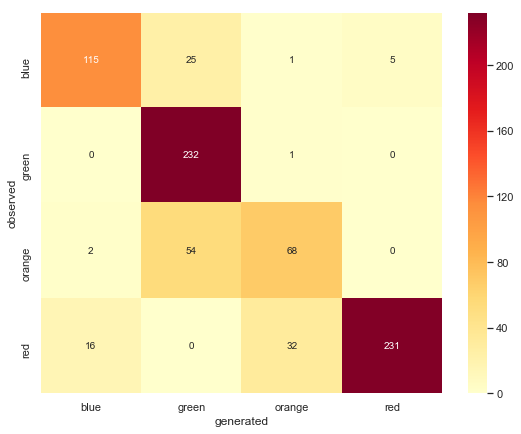

In [19]:
plt.figure(figsize=(9, 7))
sns.heatmap(
    confusion_matrix(other['modularity_class'], bikepoints['modularity_class'], labels=['blue', 'green', 'orange', 'red']),
    cmap=plt.cm.YlOrRd,
    annot=True,
    fmt='',
    xticklabels=['blue', 'green', 'orange', 'red'],
    yticklabels=['blue', 'green', 'orange', 'red'],
)
plt.xlabel('generated')
plt.ylabel('observed')
plt.savefig('img/confusion_matrix.pdf')